In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

In [3]:
!pip install arxiv wikipedia

In [4]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [5]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [6]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [ ]:
tools=[wiki_tool]#here only using 1 tool

In [8]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [9]:
from langgraph.graph import StateGraph,START,END

In [10]:
graph_builder= StateGraph(State)


In [11]:
from langchain_groq import ChatGroq

In [12]:
# from google.colab import userdata
# groq_api_key=os.getenv('GROQ_API_KEY')
groq_api_key="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"
# langsmith=os.getenv('LANGSMITH_API_KEY')
langsmith="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"
print(langsmith)


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


In [13]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002596D9202E0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002596DB2DAB0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [14]:
llm_with_tools=llm.bind_tools(tools=tools)

In [15]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [16]:
from langgraph.prebuilt import ToolNode,tools_condition

In [17]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [18]:
graph=graph_builder.compile()

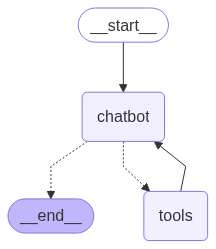

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
user_input="Hi there!, My name is Abel"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is Abel
================================== Ai Message ==================================
Tool Calls:
  wikipedia (mkd2rcrmh)
 Call ID: mkd2rcrmh
  Args:
    query: Abel
================================= Tool Message =================================
Name: wikipedia

Page: Abel
Summary: Abel (Hebrew: הֶבֶל Hébel, in pausa הָבֶל‎ Hā́ḇel; Biblical Greek: Ἅβελ Hábel; Arabic: هابيل, Hābēl) is a biblical figure in the Book of Genesis within the Abrahamic religions. Born as the second son of Adam and Eve, the first two humans created by God, he was a shepherd who offe
================================== Ai Message ==================================

Abel was the second son of Adam and Eve.


In [22]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (389kyhx6d)
 Call ID: 389kyhx6d
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other mo
================================== Ai Message ==================================

Reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other models.
